# Dinamika golf žogice

Glavni cilji:
&nbsp;dobiti gibalno enačbo golf žogice iz podatkov udarca
&nbsp;se približati realni trijektoriji
&nbsp;raziskati vpliv udarca na višji/nižji položaj
&nbsp;Preseti za različne palice

dodatki/ideje:
&nbsp;user interface
&nbsp;video celotne poti žoge
&nbsp;kompatibilnost z podatki iz launch monitorja

gibalna enačba zahteve:
&nbsp;upor se spremenja z renoldsovem stevilu
&nbsp;funkcijo koeficienta upora dobimo z interpolacijo vrednosti (https://sci-hub.se/https://doi.org/10.1016/j.proeng.2011.05.077)

&nbsp;dobimo gibalno enačbo jo dvakrat integriramo po času in dobimo enačbo za pot
&nbsp;rešimo sistem enačb in dobimo pozicijo žoge ob vsakem času

Uvozimo knjižnice potrebne za izvajanje programa ter nastavimo ostale parametre glede programa samega

In [644]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from src import UI, environment, ball, flight_calculation
from importlib import reload

sym.init_printing(use_latex=True)

import ipywidgets as widgets
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension

Izberemo palico (Pw, Sw..., Driver) ter žogo (Titleist, Callaway, TaylorMade, generic), ali pa nastavimo poljubne parametre.


In [645]:
reload(UI)
UI.user_interface_club_ball()


Checkbox(value=True, description='Uporabi Pre-set parametre')

## Nastavimo parametre okolja
Parametri so že nastavljeni na vrednosti pri morski gladini in brez vetra, lahko pa jih spreminjate v okviru dovoljenih mej.
0° pomeni veter v hrbet, kot pa se povečuje v nasprotni smeri urinega kazalca

In [646]:
reload(UI)
UI.user_interface_environment()

IntSlider(value=25, description='Temperatura okolice [°C]', layout=Layout(width='400px'), max=40, min=-10, sty…

FloatSlider(value=1.01, description='Tlak okolice [Bar]', layout=Layout(width='400px'), max=1.5, step=0.01, st…

IntSlider(value=0, description='Hitrost vetra [m/s]', layout=Layout(width='400px'), max=20, style=SliderStyle(…

IntSlider(value=0, description='Smer vetra [°]', layout=Layout(width='400px'), max=360, style=SliderStyle(desc…

In [647]:
environment.calculate_viscosity()

## Matematični Uvod

Na žogico v letu deluje veliko različbih faktorjev, v tem projektu bom poskusil zajeti dejavnike z največjim vplivom na let.
<br> Te dejavniki so:
- Zračni upor
- Magnus efekt
- Veter
- Gravitacija

<br>Ti dejavniki so pa odvisni od temperature, tlaka, hitrosti itd.
<br>Poglejmo si kako lahko zapišemo vpliv teh faktorjev v gibalni enačbi



Silo vseh komponent, ki delujejo na žogico v letu lahko zapišemo tako:

<br>$\vec{\ddot{r}}\cdot m_{zogica}  = \vec{F}_{upora}+\vec{F}_{magnus}+\vec{F}_{veter}+\vec{F}_{g}$

<br>Da izrazimo vektor pospeška žoge delimo enačbo z $m_{zogica}$ in dobimo

<br>$\vec{\ddot{r}} = \vec{F}_{upora}/m_{zogice}+\vec{F}_{magnus}/m_{zogice}+\vec{F}_{veter}/m_{zogice}+\vec{g}$

<br>Zdaj pa moramo definirati vsako neznano silo


## Izpeljava sile zračnega upora

<br>Silo zračnega upora modeliramo po kvadratnemu zakonu upora

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\vec{F} = \frac{1}{2}\cdot C_{d}\cdot \rho \cdot A \cdot \vec{v} \odot \vec{v}$

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;kjer $\odot$ označuje operacijo množenja vektorjev po elementih

**poiščimo neznanke:**

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$C_{d}$ bomo spodaj izračunali s pomočjo interpolacije saj ni konstanten, temveč odvisen od hitrosti

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\rho [\frac{Kg}{m^3}]$ bomo izračunali po zakonu idealnih plinov $\rho = \frac{p}{R \cdot T}$, kjer je:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- $p$ tlak [$Pa$]
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- $R$ specifična plinska konstanta [$\frac{J}{Kg \cdot K}$]
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- $T$ temperatura [$K$]

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$A [m^2]$ je projektirana površina, ki se upira zraku izračunana po formuli $A = \pi r^{2}$

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\vec{v}$ pa je spremenljivka

### Interpolacija funkcije koeficienta trenja v odvisnosti od Reynoldsovega števila

Izkaže se, da je koeficient trenja $C_{d}$ odvisen od hitrosti potovanja žogice relativno za okoliški zrak. Študija [1] raziskuje ravno to relacijo, v svojih eksperimentih so uporabili odvisnost $C_{d}$ od Reynoldsovega števila. Iz njihovih rezultatov sem shranil nekaj izmerjenih točk za različne proizvajalce golf žogic.
<br>Poglejmo si izmerjene podatke za vse tri žogice

Text(0, 0.5, 'Koeficient trenja')

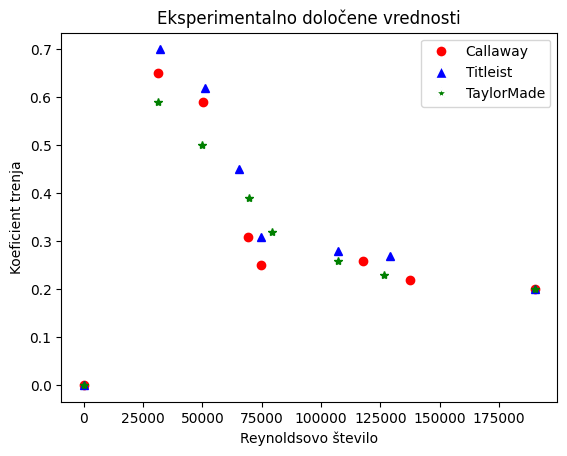

In [648]:
reload(ball)

def print_points():
    calloway = ball.read_ball_data(ball_type="Calloway")
    titleist = ball.read_ball_data(ball_type="Titleist")
    taylormade = ball.read_ball_data(ball_type="TaylorMade")

    plt.plot(calloway[:, 0], calloway[:, 1], "ro")
    plt.plot(titleist[:, 0], titleist[:, 1], "b^")
    plt.plot(taylormade[:, 0], taylormade[:, 1], "g*")

print_points()

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='b', markersize=8),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='g', markersize=8)
]
legend_labels = ["Callaway", "Titleist", "TaylorMade"]

plt.legend(legend_handles, legend_labels)

plt.title("Eksperimentalno določene vrednosti")

#plt.xlim(49000,120000)
plt.xlabel("Reynoldsovo število")
plt.ylabel("Koeficient trenja")


Očitno je koeficient odvisen od Renoldsovega števila. Zanimiva je tudi razlika med karekteristikami proizvajalca.
<br>Da pa to karakteristiko popišemo potrebujemo funkcijo, da lahko pri poljubnem Renoldsovem številu dobimo koeficient trenja. To naredimo z interpolacijo, interpoliramo z uporabo knjižnice scipy.
<br><br>Poglejmo rezultantne funkcije


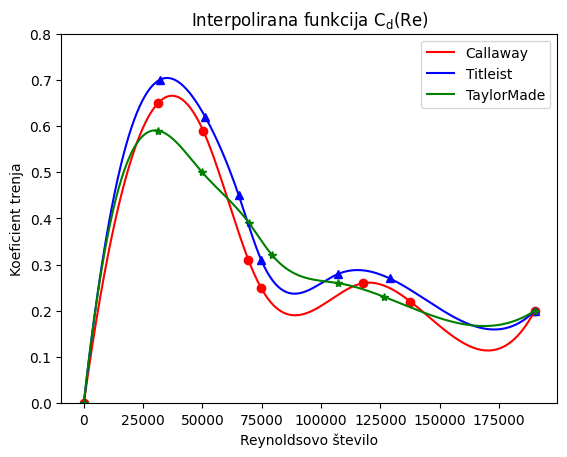

In [649]:
reload(ball)
s_ca = ball.c_d_re_interpolation(ball_type="Calloway")
s_ti = ball.c_d_re_interpolation(ball_type="Titleist")
s_ta = ball.c_d_re_interpolation(ball_type="TaylorMade")

test_x = np.linspace(0, 190000, 1000)
test_y_ca = s_ca(test_x)
test_y_ti = s_ti(test_x)
test_y_ta = s_ta(test_x)

plt.title(r"Interpolirana funkcija $\mathregular{C_d}$(Re)")
plt.xlabel("Reynoldsovo število")
plt.ylabel("Koeficient trenja")

print_points()

legend_handles = [
    plt.Line2D([0], [0], color='r', markersize=8),
    plt.Line2D([0], [0], color='b', markersize=8),
    plt.Line2D([0], [0], color='g', markersize=8)
]

legend_labels = ["Callaway", "Titleist", "TaylorMade"]

plt.legend(legend_handles, legend_labels)
plt.xlim()
plt.ylim(0, 0.8)

plt.plot(test_x, test_y_ca, "r")
plt.plot(test_x, test_y_ti, "b")
plt.plot(test_x, test_y_ta, "g")



In [650]:
0.5*101000*np.pi*0.02**2/(287*295)*np.array([2500 * s_ca(70000),0,225* s_ca(70000)])

array([0.56548767, 0.        , 0.05089389])

In tako smo definirali vse neznanke za modeliranje zračnega upora.
<br><br>Končna formula zračnega upora je torej $\vec{F} = \frac{1}{2}\cdot \frac{p}{R \cdot T} \cdot \pi r^{2} \cdot \vec{v} \odot \vec{v} \odot S_{zoge}(\vec{v})$

## Izpeljava sile vzgona (Magnus efekt)

<br>Sila sledeča iz magnus efekta se definira kot  $\vec{F}=S(\vec{\omega}\times \vec{v})$

<br>$\vec{\omega}$ bomo vzeli kot podan podatek in predpostavili, da se skozi let ne spreminja.

<br>$\vec{v}$ je tako kot prej spremenljivka

<br>$S$ pa bomo izpeljali iz bernoullijeve enačbe in knjižnice za simbolno računanje sympy

### Izpeljava $S$ z sympy

Bernoullijeva enačba z izpostevljeno spremembo tlaka
<br><br>$\Delta p=\frac{\rho}{2}(\vec{v_{a}}^{2}-\vec{v_{b}}^{2})$
<br><br>Želimo pa vstaviti vrednosti za $\vec{v_{a}}^{2}$ in $\vec{v_{b}}^{2}$ te dve hitrosti si lahko predstavljamo, kot hitrost z katero zrak obteka žogo. To hitrost lahko zapišemo kot  $\vec{v_{a}}=\vec{v_{0}}-\vec{\omega}\times\vec{r}$ in podobno tudi za $\vec{v_{b}}$
<br>Z nadalnjo poenostavitvijo dobimo $\Delta p = \frac{1}{2} \rho r (\vec{\omega}\times \vec{v})$
<br>Vemo, da je $\vec{F} = \int_{A}^{}\Delta p\text{ }dA$ in ko vstavimo vidimo, da je $\vec{F} = \frac{1}{2} \rho r (\vec{\omega}\times \vec{v}) \cdot \int_{A}^{}dA = \frac{1}{2} \rho A r (\vec{\omega}\times \vec{v})$. Iz tega pa razberemo, da je $S = \frac{1}{2} \rho A r$

In [651]:
rho, r, r_1_s = sym.symbols("rho, r r_1", positive=True)
w = sym.Matrix(sym.MatrixSymbol("w", 3, 1))
v = sym.Matrix(sym.MatrixSymbol("v", 3, 1))

sedaj rabimo izračunati A. A je povprečna projektirana površina žogice. To izračunamo tako, da izenačimo ploščino sredinskega kroga (z radijem $r_1$)
<br>ter ploščino kolobara (z notranjim radijem $r_1$ in zunanjim radijem $r$) in izračunamo $r_1$, ki je radius kroga z povprečno projektirano površino


In [652]:
A_1 = sym.pi * r_1_s ** 2
A_k = sym.pi * r ** 2 - A_1
r_1 = sym.solve(sym.Eq(A_1, A_k), r_1_s, positive=True)
r_1[0]

izračunali smo da je $r_1 = \frac{r}{\sqrt{2}}$ sedaj lahko zapišemo celotno enačbo za $S$
<br>$S = \rho r_{1}^{3} \pi$
<br>in to poračunamo z $\vec{\omega}\times \vec{v}$


In [653]:
F = 2 * rho * r_1[0] ** 2 * r * sym.pi * w.cross(v)
F

⎡   3                       ⎤
⎢π⋅r ⋅ρ⋅(-v₁₀⋅w₂₀ + v₂₀⋅w₁₀)⎥
⎢                           ⎥
⎢   3                       ⎥
⎢π⋅r ⋅ρ⋅(v₀₀⋅w₂₀ - v₂₀⋅w₀₀) ⎥
⎢                           ⎥
⎢   3                       ⎥
⎣π⋅r ⋅ρ⋅(-v₀₀⋅w₁₀ + v₁₀⋅w₀₀)⎦

nato pa spremenimo v numerično funkcijo z predvstavljenimi konstantnimi vrednostmi

In [654]:
F = F.subs({w[0]:0, w[1]:200, w[2]:0, rho:1.3, r:0.02})
f = sym.lambdify(v, F, "numpy")

## Izpeljava sile vetra

Silo delujočo na žogico med letom bomo izračunali po neslednji formuli
<br><br> $F_{vetra} = 0.5 \cdot \rho \cdot \vec{V}_{vetra}^{2} \cdot A$

<br> podatek A imamo izrečunan že od prej, $\rho$ izračunamo na podlagi temperature ter tlaka, hitrost vetra pa je podana. Ta enačba je poenostavljena, meddrugim tudi ne upošteva gradienta vetra, sunkov vetra, nehomogenost zračne mase itd.

In [655]:
F_v = 0.5 * 1.3*100*np.pi*0.02**2
F_v

## Giblana enačba

<br>sestavljena gibalna enačba izgleda nekako tako

$$\vec{\ddot{r}} = \frac{1}{2}\cdot \frac{p}{R \cdot T} \cdot \pi r^{2} \cdot \vec{v} \odot \vec{v} \odot S_{zoge}(\vec{v})\frac{1}{m} + 
\rho\,\frac{1}{2} \rho A r (\vec{\omega}\times \vec{v})+
 0.5 \cdot \rho \cdot \vec{V}_{vetra}^{2} \cdot A \cdot \frac{1}{m}+
 \vec{g}
$$

<br>Sedaj pa jo numerično implementiramo, numeročno kalkulacijo opravimo v "flight_calculation.py" skripti tukaj pa dobimo rezulatate s klicom funkcije "calculate_trajectory". Funkciji podamo seznam časovnih točk v časovnem okviru $n$ in z časovni resoluciji $r$ ter interpolirano funkcijo $C_d(Re)$


## 

[   0 -200    0]


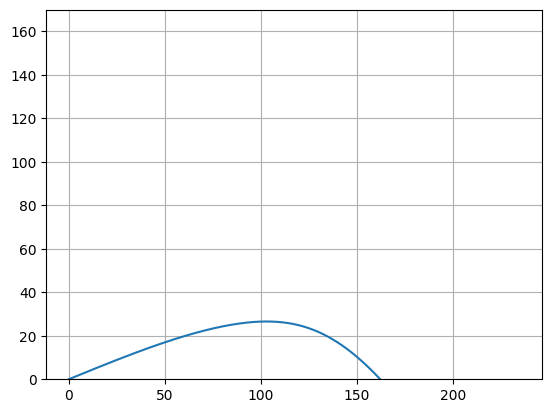

In [672]:
reload(flight_calculation)
reload(environment)
reload(ball)

n = 10
res = 1000
t_points = np.linspace(0, n, res)

flight_data = flight_calculation.calculate_trajectory(s_ta, t_points=t_points)


plt.plot(flight_data[:, 3], flight_data[:,5])
plt.grid()
plt.ylim(0,170)


Z funkcijo "analize_flight" dobimo podatke o dolžini udarca maksimalni višini leta ter čas leta 

Text(0, 0.5, 'Višina 26.58m')

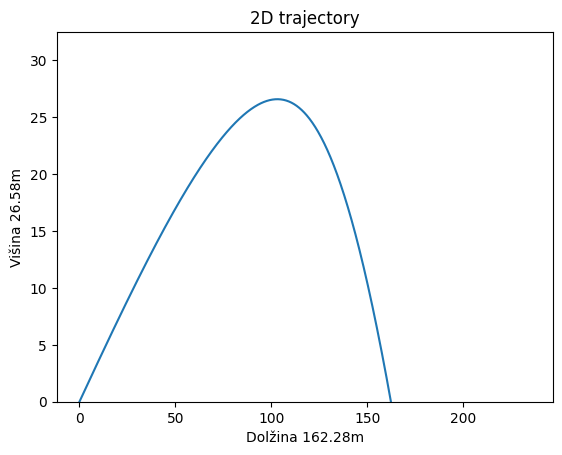

In [673]:
reload(flight_calculation)
flight = flight_calculation.analize_flight(flight_data, n)

distance = flight[0]
max_altitude = flight[1]
flight_time = flight[2]
max_amplitude = flight[3]

# x/z
plt.plot(flight_data[:, 3], flight_data[:, 5])
plt.ylim(0)
plt.title("2D trajectory")
plt.xlabel(f"Dolžina {distance}m")
plt.ylabel(f"Višina {max_altitude}m")

Text(0, 0.5, 'Zavoj 0.0m')

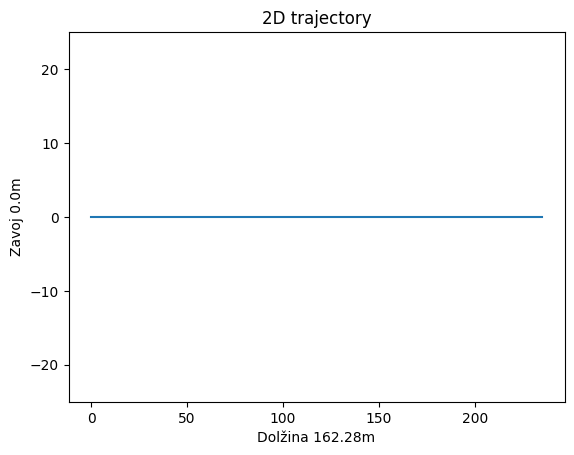

In [674]:
# x/y
plt.plot(flight_data[:, 3], flight_data[:, 4])
plt.ylim(-25, 25)
plt.title("2D trajectory")
plt.xlabel(f"Dolžina {distance}m")
plt.ylabel(f"Zavoj {max_amplitude}m")

In [ ]:
ball.get_club_data("6_iron")